<a href="https://colab.research.google.com/github/vishalaadee/Segmentation-Self-Driving-Cars/blob/main/segmentation%20-Mobilenet%20Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img,array_to_img,img_to_array
import skimage
import keras
def plotter(img,mask):
    fig,axes=plt.subplots(1,2)
    axes[0].imshow(img)
    plt.imshow(mask)
    
rgb_dir= '/content/drive/MyDrive/deep learning/CameraRGB'
seg_dir= '/content/drive/MyDrive/deep learning/CameraSeg'
images_path = list(sorted([ os.path.join(rgb_dir, fname) for fname in os.listdir(rgb_dir) ]))
segmentations_path = list(sorted([ os.path.join(seg_dir, fname) for fname in os.listdir(seg_dir)]))

import random
val_samples = 1200
images=[]
annotations=[]
for i in range(2000):
    img1,mask1= cv2.imread(images_path[i]),cv2.imread(segmentations_path[i])[:,:,2]
    img1=cv2.resize(img1,(256,256))
    mask1=cv2.resize(mask1,(256,256,))
    images.append(img1)
    annotations.append(mask1)
images=np.array(images)
annotations=np.array(annotations)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if __name__ == '__main__':


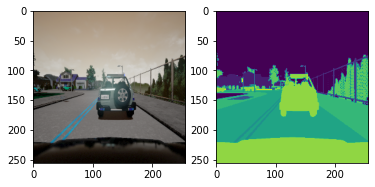

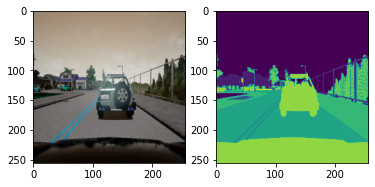

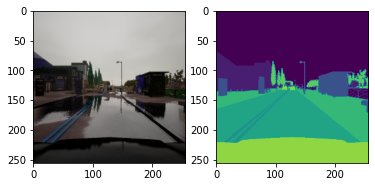

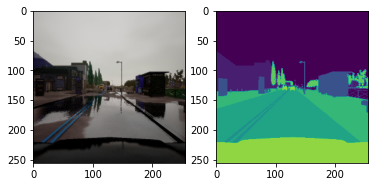

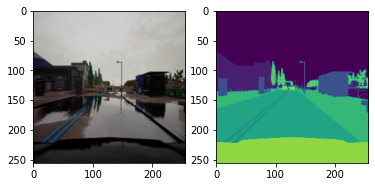

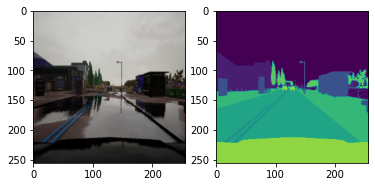

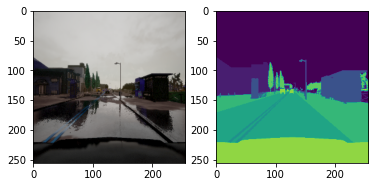

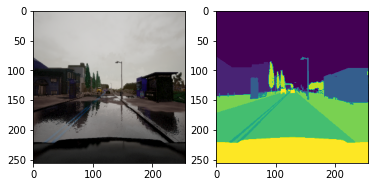

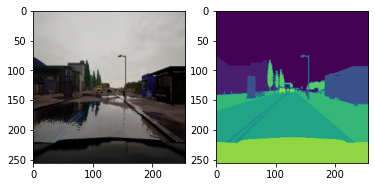

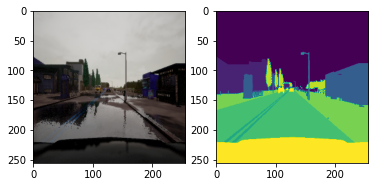

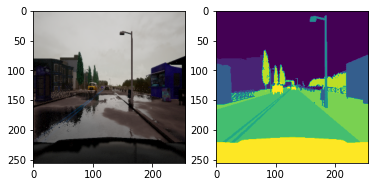

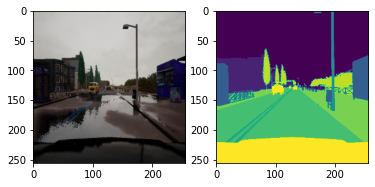

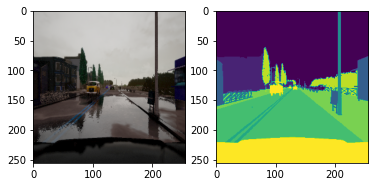

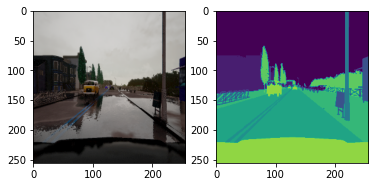

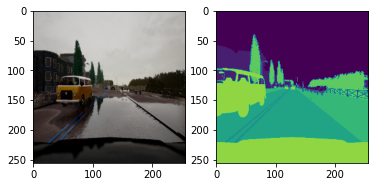

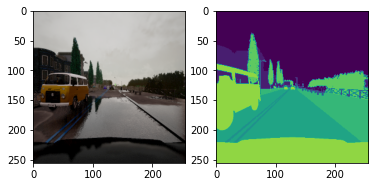

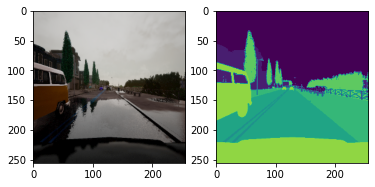

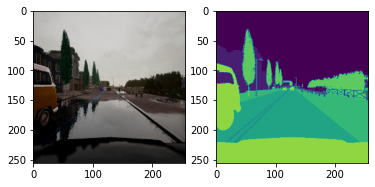

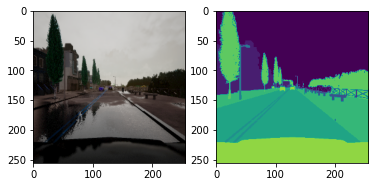

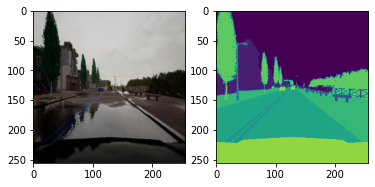

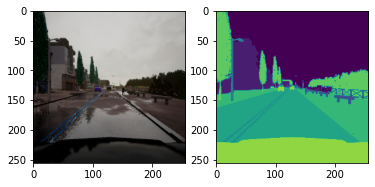

In [6]:
for i in range(998,1019):
    plotter(images[i],annotations[i])

In [7]:
random.Random(1800).shuffle(images)
random.Random(1800).shuffle(annotations)
train_data=images[:-val_samples]
train_annotate=annotations[:-val_samples]
valid_data=images[-val_samples:]
valid_annotate=annotations[-val_samples:]

In [8]:
from tensorflow.keras import layers
def get_model():
    inputs = keras.Input(shape= (256,256) + (3,))
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = [ "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    x = encoder.get_layer("block_13_expand_relu").output
    previous_block_activation = x 
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  
        previous_block_activation = x 

    outputs = layers.Conv2D(13, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    
    
    return model

In [9]:
keras.backend.clear_session()
model = get_model()
model.summary()
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks = [
    keras.callbacks.ModelCheckpoint("carlasimu.h5", save_best_only=True),
]

epochs = 15

2023424/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 16) 64          Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 16) 0           bn_Conv1[0][0]                   
_______________________________

In [10]:

history=model.fit(
    images,annotations,validation_split=0.3,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
44/44 [==============================] - 804s 18s/step - loss: 2.6932 - accuracy: 0.6534 - val_loss: 1.3125 - val_accuracy: 0.6312
Epoch 2/25
44/44 [==============================] - 769s 18s/step - loss: 0.5606 - accuracy: 0.8414 - val_loss: 0.8591 - val_accuracy: 0.7574
Epoch 3/25
44/44 [==============================] - 756s 17s/step - loss: 0.4579 - accuracy: 0.8671 - val_loss: 1.8394 - val_accuracy: 0.6770
Epoch 4/25
44/44 [==============================] - 752s 17s/step - loss: 0.4170 - accuracy: 0.8783 - val_loss: 0.6840 - val_accuracy: 0.7995
Epoch 5/25
44/44 [==============================] - 759s 17s/step - loss: 0.3940 - accuracy: 0.8830 - val_loss: 0.6140 - val_accuracy: 0.8194
Epoch 6/25
44/44 [==============================] - 756s 17s/step - loss: 0.3645 - accuracy: 0.8911 - val_loss: 0.5795 - val_accuracy: 0.8332
Epoch 7/25
44/44 [==============================] - 751s 17s/step - loss: 0.3353 - accuracy: 0.8995 - val_loss: 0.5812 - val_accuracy: 0.8302
Epoch 

(1, 256, 256, 13)
[[[[6.68894947e-01 1.34279272e-02 2.84028966e-02 ... 1.81035958e-02
    4.29227948e-03 8.65186739e-05]
   [9.06223655e-01 5.29085798e-03 6.90471334e-03 ... 2.74245883e-03
    2.28635807e-04 1.44356254e-05]
   [9.30184960e-01 3.95237328e-03 5.92386676e-03 ... 2.57851277e-03
    2.01704956e-04 1.78772534e-05]
   ...
   [9.76959288e-01 4.20481345e-04 9.30602138e-04 ... 1.82567537e-03
    6.91966852e-04 8.41421497e-05]
   [9.74146128e-01 4.08611697e-04 1.23298063e-03 ... 2.04943516e-03
    7.86649471e-04 8.84545734e-05]
   [9.44258273e-01 9.98340314e-04 1.00703572e-03 ... 7.23091885e-03
    3.63405026e-03 1.35738472e-03]]

  [[8.58552814e-01 1.34657035e-02 6.24909252e-03 ... 7.79797905e-04
    1.17056836e-04 2.01926014e-05]
   [9.50402737e-01 3.96896992e-03 1.02887908e-03 ... 5.87023351e-05
    4.04670800e-06 1.74511297e-06]
   [9.73305106e-01 1.86317030e-03 6.51134702e-04 ... 4.29473221e-05
    3.41956707e-06 2.32199136e-06]
   ...
   [9.94911969e-01 6.98681397e-05 1.172

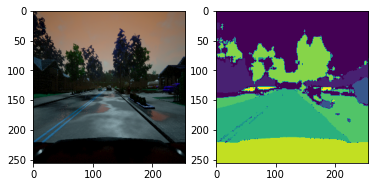

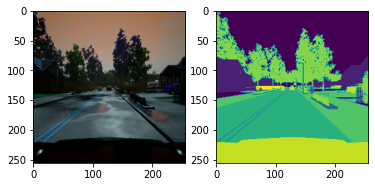

In [15]:
test = images[1999]
getshape=test.shape
pred = model.predict(test.reshape(1,getshape[0],getshape[1],getshape[2]))

print(pred.shape)        
newimg = np.zeros((256,256))
print(pred)
for i in range(13):
    for j in range(256):
        for k in range(256):
            if pred[0,j,k,i] > 0.5:
                newimg[j,k] = i

plotter(test,newimg)
plotter(test,annotations[1999])